# Global wheat-head detection

### Data
(1) a dataset of wheat-head images  
(2) a csv file specifying all bounding boxes

* The raw data is provided from the Kaggle challange - Global Wheat-head Detection :  
https://www.kaggle.com/c/global-wheat-detection/data
* The original data is combined with augmneted data created using the Albumentation library. The augmented image generator is available in an additional notebook
* The data is uploaded in COCO format (x,y,width,height) and transferred to VOC-PASCAL format (Xmin, Ymin, Xmax, Ymax)

### Model
The following models were considered:
- Faster RCNN - Region based convolutional neural net    
I used an RCNN model from the torchvision library which was pretrained using resnet50. Initial RoI (regions of interest) are passed through CNN to define 4-parameters rectangles
- YOLO - "You Only Look Once"  
YOLO is generally more efficient model which trains each image as a grid to produce a vector that defines the existance of an object, its bboxes and labels.

### Evaluation
The score of each bbox prediction is based on the IoU metric (intersection of union). The number of detections is a function of the threshold - the minimal IoU score that is considered as a right detection. 

# Import Files and Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
DIR = '/content/drive/My Drive/Wheat Data'
IMAGES_PATH = f'{DIR}/all images'
TRAIN_CSV_PATH =  f'{DIR}/train.csv'
AUG_CSV_PATH =  f'{DIR}/augmented.csv'
TEST_PATH = f'{DIR}/test'
TEST_CSV_PATH = f'{TEST_PATH}/sample_submission.csv'
USE_CUDA = True
IMPORT_DRIVE = True

In [3]:
if IMPORT_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
raw_csv = pd.read_csv(TRAIN_CSV_PATH)
raw_csv.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
aug_csv = pd.read_csv(AUG_CSV_PATH)
aug_csv.head()

,image_id,Xmin,Ymin,Xmax,Ymax
0,aug_0_00333207f.jpg,0,654,37,765
1,aug_0_00333207f.jpg,0,817,135,915
2,aug_0_00333207f.jpg,0,192,22,273
3,aug_0_00333207f.jpg,4,342,67,380
4,aug_0_00333207f.jpg,82,334,164,415


In [6]:
os.chdir(IMAGES_PATH)
os.listdir()[:5], len(os.listdir())

(['aug_2427_b61ff5016.jpg',
  'aug_2428_b6265c083.jpg',
  'aug_2433_b67b3c007.jpg',
  'aug_2434_b67b4d2e8.jpg',
  'aug_2432_b65e07813.jpg'],
 6849)

In [7]:
# Check which of the zipped images appear in the csv
files_ls = [file_name for file_name in os.listdir() if '.jpg' in file_name]
df_ls = raw_csv['image_id'].unique()
adf_ls = aug_csv['image_id'].unique()
inter_ls = [value for value in df_ls if value +'.jpg' in files_ls]
aug_inter_ls = [value for value in adf_ls if value in files_ls]

print(f'number of images uploaded : {len(files_ls)}')
print(f'number of images in original csv : {len(df_ls)}')
print(f'number of images in the self-made csv of augmented images: {len(adf_ls)}')
print(f'number of images uploaded and in csv: {len(inter_ls)}')
print(f'number of images uploaded and in aug-csv: {len(aug_inter_ls)}')

raw_data = raw_csv[raw_csv['image_id'].isin(inter_ls)]
raw_data.head()

number of images uploaded : 6844
number of images in original csv : 3373
number of images in the self-made csv of augmented images: 3373
number of images uploaded and in csv: 3373
number of images uploaded and in aug-csv: 3373


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


# Preprocessing

### Modify DataFrame and check input validity

In [8]:
def modify_df(coco_df):
  bboxes = np.stack(coco_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
  df = pd.DataFrame(bboxes, columns = ['Xmin', 'Ymin','width', 'height'])
  id_col = coco_df['image_id'].reset_index().drop('index', axis=1)
  id_col = id_col + '.jpg'
  df = df.join(id_col)
  df['Xmax'] = df.apply(lambda col: col['Xmin'] + col['width'], axis=1)
  df['Ymax'] = df.apply(lambda col: col['Ymin'] + col['height'], axis = 1)
  del df["width"]
  del df["height"]
  df = df[['image_id','Xmin', 'Ymin','Xmax','Ymax']]
  return df

raw_data = modify_df(raw_data)
raw_data.head()

,image_id,Xmin,Ymin,Xmax,Ymax
0,b6ab77fd7.jpg,834.0,222.0,890.0,258.0
1,b6ab77fd7.jpg,226.0,548.0,356.0,606.0
2,b6ab77fd7.jpg,377.0,504.0,451.0,664.0
3,b6ab77fd7.jpg,834.0,95.0,943.0,202.0
4,b6ab77fd7.jpg,26.0,144.0,150.0,261.0


In [9]:
# add augmentations
data = pd.concat([raw_data, aug_csv])
data.tail()

,image_id,Xmin,Ymin,Xmax,Ymax
147788,aug_3421_ffdf83e42.jpg,4.0,536.0,78.0,605.0
147789,aug_3421_ffdf83e42.jpg,68.0,321.0,127.0,377.0
147790,aug_3421_ffdf83e42.jpg,472.0,31.0,534.0,112.0
147791,aug_3421_ffdf83e42.jpg,779.0,585.0,845.0,681.0
147792,aug_3421_ffdf83e42.jpg,745.0,229.0,824.0,281.0


In [10]:
# check out-of-boundaries boxes
oob = data[(data["Ymax"] > 1024) | (data["Ymax"] > 1024) | (data["Xmin"] < 0) | (data["Ymin"] < 0)]
oob

,image_id,Xmin,Ymin,Xmax,Ymax


In [11]:
modified_ls = data['image_id'].unique()
print(f'number of images uploaded : {len(files_ls)}')
print(f'number of images in original csv : {len(modified_ls)}')
# Check images without any wheat-heads
no_heads = [value for value in files_ls if value not in modified_ls]
print(f'number of images without bboxes : {len(no_heads)}')

number of images uploaded : 6844
number of images in original csv : 6746
number of images without bboxes : 98


In [12]:
 records = data[data['image_id'] == no_heads[0]]
 boxes = records[['Xmin', 'Ymin', 'Xmax', 'Ymax']].values
 boxes, len(records)

(array([], shape=(0, 4), dtype=float64), 0)

## Prepare PyTorch Dataset

In [13]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, id_list):
        super().__init__()

        self.image_ids = np.array(id_list) #dataframe['image_id'].unique()
        self.df = dataframe

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        # create a subset dataframe of the image's boxes
        records = self.df[self.df['image_id'] == image_id]
        
        # Define an image object as 0-1 float
        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # pascal-voc format for the bboxes
        boxes = records[['Xmin', 'Ymin', 'Xmax', 'Ymax']].values
        # only one class for the labels
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.FloatTensor(boxes)
        target['labels'] = torch.LongTensor(labels)
        target['image_id'] = torch.tensor([index])
        image_transform = torchvision.transforms.ToTensor()
        image = image_transform(image)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [14]:
def split_images(df, p=0.2):
  image_ids = df['image_id'].unique()
  random.shuffle(image_ids)
  cutoff = int(len(image_ids)*p)
  valid_ids = image_ids[-cutoff:]
  train_ids = image_ids[:-cutoff]
  valid_df = df[df['image_id'].isin(valid_ids)]
  train_df = df[df['image_id'].isin(train_ids)]
  return train_df, valid_df
  
train_df, valid_df = split_images(data, p=0.2)
len(train_df), len(valid_df)

(237001, 58585)

In [15]:
train_df.head()

,image_id,Xmin,Ymin,Xmax,Ymax
93,7b72ea0fb.jpg,332.0,662.0,445.0,712.0
94,7b72ea0fb.jpg,285.0,755.0,316.0,789.0
95,7b72ea0fb.jpg,126.0,464.0,191.0,517.0
96,7b72ea0fb.jpg,363.0,262.0,431.0,407.0
97,7b72ea0fb.jpg,912.0,656.0,1009.0,732.0


In [16]:
valid_list = list(valid_df['image_id'].unique()) + list(random.sample(no_heads, int(len(no_heads)/5)))
train_list = [name for name in files_ls if name not in valid_list]
random.shuffle(train_list)
random.shuffle(valid_list)
len(train_list), len(valid_list)

(5476, 1368)

In [17]:
train_dataset = WheatDataset(train_df, train_list)
valid_dataset = WheatDataset(valid_df, valid_list)

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16, 
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

### EDA and Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a34eb97b8>]],
      dtype=object)

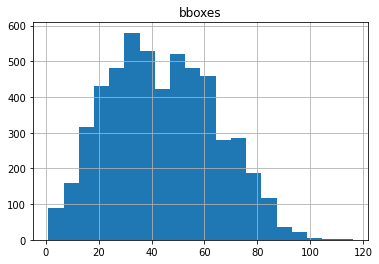

In [19]:
train_images_count = train_df.groupby('image_id').count().reset_index().rename(columns={"Xmin": "bboxes"}).drop(['Ymin','Xmax','Ymax'], axis=1)
train_images_count.hist('bboxes', bins=20)

In [20]:
def boxed_image(sample):
  image, target, im_id = sample
  img = image.permute(1,2,0).numpy()
  img = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
  img = (img * 255).astype(np.uint8)
  #img = cv2.imread(im_id)
  boxes = target['boxes']
  thickness=8
  color = [255,0,0]
  if len(boxes>0):
            for box in boxes:
                stpt = int(box[0]), int(box[1])
                endpt = int(box[2]), int(box[3])         
                img = cv2.rectangle(img,stpt,endpt,color,thickness)
  return img

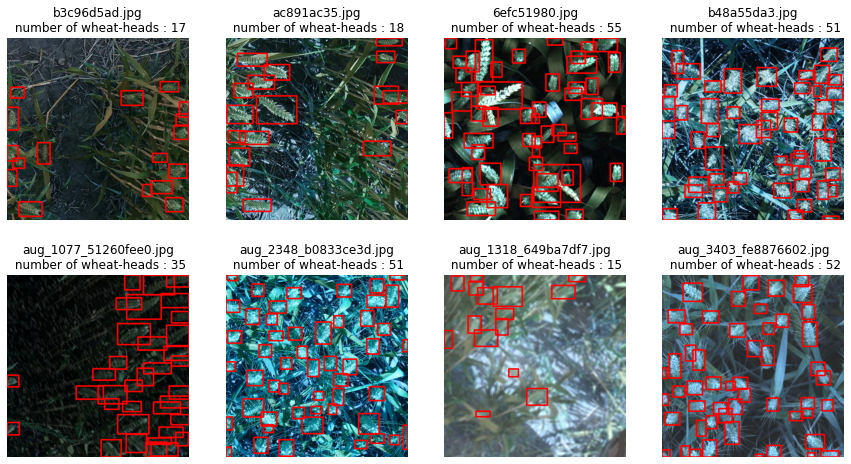

In [21]:
# Create a random list of image indices to present
names_array = np.array(train_list)
rand_list = np.random.randint(len(train_dataset),size = 8)    
fig = plt.figure(figsize=(15,8))
for i, ind in enumerate(rand_list):
  sample = train_dataset[ind]
  ax = fig.add_subplot(2,4,i+1)
  img = boxed_image(sample)
  title = sample[2] + '\n number of wheat-heads : ' +str(len(sample[1]['boxes']))
  ax.set_title(title)
  ax.axis(False)
  #ax.imshow((img * 255).astype(np.uint8))
  ax.imshow(img)
plt.show()

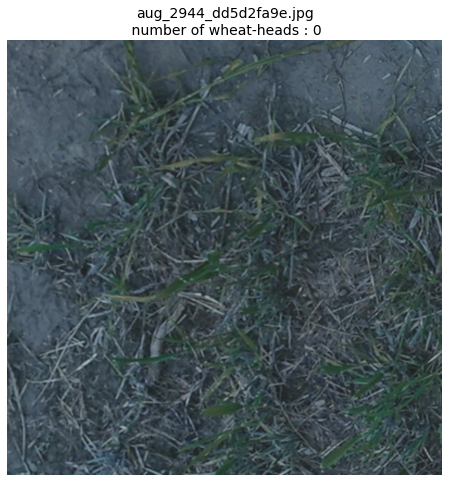

In [22]:
image_id = no_heads[8]
records = data[data['image_id']==image_id]
single_object = WheatDataset(records, [image_id])
sample = single_object[0]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.axis(False)
img = boxed_image(sample)
title = sample[2] + '\n number of wheat-heads : ' +str(len(sample[1]['boxes']))
ax.set_title(title, fontsize = 14)
ax.imshow(img)
plt.show()


# Model

In [23]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set roi_heads.box_predictor
num_classes = 2  # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [24]:
if USE_CUDA and torch.cuda.is_available():
    model.cuda()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6197560165968032592, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8726165441069304559
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1680881941288469422
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15094296128
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11199549825459096999
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [25]:
for i, sample in enumerate(train_data_loader):
  image_list, targets_list, id_list = sample 
  print(type(image_list[0]), image_list[0].shape)
  print(type(targets_list[0]), targets_list[0].keys())
  print(type(id_list[0]), id_list[0])
  print('*****************************************')
  if i>=2: 
    break

<class 'torch.Tensor'> torch.Size([3, 1024, 1024])
<class 'dict'> dict_keys(['boxes', 'labels', 'image_id'])
<class 'numpy.str_'> aug_3181_eeb2213cd.jpg
*****************************************
<class 'torch.Tensor'> torch.Size([3, 1024, 1024])
<class 'dict'> dict_keys(['boxes', 'labels', 'image_id'])
<class 'numpy.str_'> fdbdb35fc.jpg
*****************************************
<class 'torch.Tensor'> torch.Size([3, 1024, 1024])
<class 'dict'> dict_keys(['boxes', 'labels', 'image_id'])
<class 'numpy.str_'> aug_1959_94ea18562.jpg
*****************************************


## Training
Hyper-parameters:
* learning rate and learning decay (step_zize/gamma)
* momentum - data-points smoothing
* weight decay - regulariztion coefficient

In [26]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [27]:
class LossTrack:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        self.loss_list= []

    def send(self, value):
        self.current_total += value
        self.iterations += 1
        self.loss_list.append(value)

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [28]:
EPOCHS = 4
loss_hist = LossTrack()
itr = 1
loss_min = 0.61 #initial minimum loss value to save the model

for epoch in range(EPOCHS):
    loss_hist.reset()
    model.train()
    
    # training loop
    for images, targets, image_ids in train_data_loader:
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        
        # summation of the losses
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
            if loss_hist.value<loss_min:
              loss_min = loss_hist.value
              model_name = f'fasterrcnn_resnet50_fpn_loss_{loss_min}.pth'
              torch.save(model.state_dict(), model_name)
              print(f'New minima: {loss_min}, saving model...')

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    #model.eval()
    #for images, targets, image_ids in valid_data_loader:
    #    images = list(image.to(device) for image in images)
    #    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    #    output = model(images)


    print(f"-> Epoch #{epoch+1} loss: {loss_hist.value}")   

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 1.0337311029434204
Iteration #100 loss: 0.7632446885108948
Iteration #150 loss: 0.8679924011230469
Iteration #200 loss: 0.6675711870193481
Iteration #250 loss: 0.6963655948638916
Iteration #300 loss: 0.8075305223464966
-> Epoch #1 loss: 0.7840672536772124
Iteration #350 loss: 0.6953675746917725
Iteration #400 loss: 0.5960500836372375
Iteration #450 loss: 0.6725510954856873
Iteration #500 loss: 0.8092301487922668
Iteration #550 loss: 0.6702784299850464
Iteration #600 loss: 0.6129058599472046
Iteration #650 loss: 0.7063003778457642
-> Epoch #2 loss: 0.6546336216064653
Iteration #700 loss: 0.6444061994552612
Iteration #750 loss: 0.6843397617340088
Iteration #800 loss: 0.7007405161857605
Iteration #850 loss: 0.6084952354431152
Iteration #900 loss: 0.5622460842132568
Iteration #950 loss: 0.6773640513420105
Iteration #1000 loss: 0.5992675423622131
-> Epoch #3 loss: 0.6219218501891757
Iteration #1050 loss: 0.5377480983734131
New minima: 0.5978556105068752, saving model...


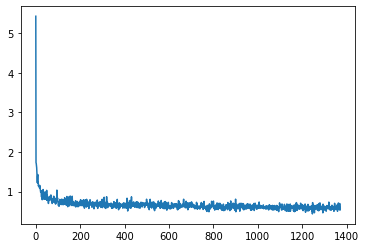

In [29]:
plt.plot(loss_hist.loss_list)

Text(0.5, 1.0, 'Training loss vs. Iterations. Final loss : 0.544')

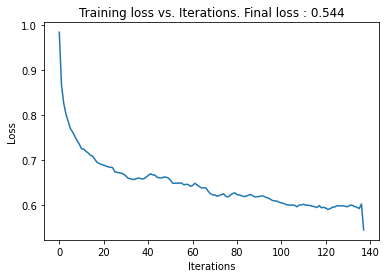

In [30]:
n=100
av_loss = [np.mean(loss_hist.loss_list[i:i + n]) for i in range(0, len(loss_hist.loss_list), 10)]
final_loss = np.round(av_loss[-1],3)
plt.plot(av_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Training loss vs. Iterations. Final loss : {final_loss}')

In [31]:
SAVE_MODEL=True
RUN_TEST = False

In [32]:
if SAVE_MODEL:
  #model_name = f'fasterrcnn_resnet50_fpn_loss_{final_loss}.pth'
  #torch.save(model.state_dict(), model_name)
  model.load_state_dict(torch.load(model_name))
  from google.colab import files
  files.download(model_name)
# load command:
# model.load_state_dict(torch.load(WEIGHTS_FILE))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

### Intersection over Union (IoU)
Intersection over Union is a measure of the magnitude of overlap between two bounding boxes (or, in the more general case, two objects). It calculates the size of the overlap between two objects, divided by the total area of the two objects combined.

It can be visualized as follows:

![](https://github.com/omrigo5/Wheat-Detection/blob/master/IoU.jpg?raw=true)

The two boxes in the visualization overlap, but the area of the overlap is insubstantial compared with the area taken up by both objects together. IoU would be low - and would likely not count as a "hit" at higher IoU thresholds.

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
model = model.to(device)
model.eval()
valid_batch = next(iter(valid_data_loader))
images, targets, image_ids = valid_batch
images = list(image.to(device) for image in images)
output = model(images)
prediction = output[0]
image_id = image_ids[0]
image = images[0]
target = targets[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Text(0.5, 1.0, '22 predicted boxes, 18 ground-truth boxes,\n score = 0.98, threshold = 0.5')

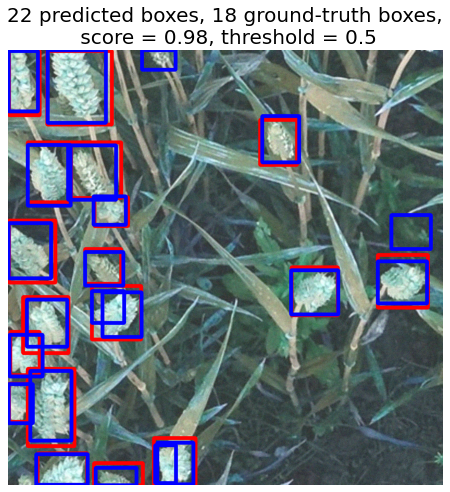

In [34]:
threshold = 0.5
boxes_gt = target['boxes']
boxes_pr= prediction['boxes'][prediction['scores']>threshold]
mdscore = np.median(prediction['scores'][prediction['scores']>threshold].cpu().detach().numpy())

img = cv2.imread(image_id)
thickness=7
for box in boxes_gt:
  stpt = int(box[0]), int(box[1])
  endpt = int(box[2]), int(box[3])
  color = [255,0,0]
  img = cv2.rectangle(img,stpt,endpt,color,thickness)
for box in boxes_pr:
  stpt = int(box[0]), int(box[1])
  endpt = int(box[2]), int(box[3])
  color = [0,0,255]
  img = cv2.rectangle(img,stpt,endpt,color,thickness)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.imshow(img)
ax.axis(False)
ax.set_title('{} predicted boxes, {} ground-truth boxes,\n score = {:.2}, threshold = {}'.format(len(boxes_pr),len(boxes_gt),mdscore,threshold), fontsize = 20)

In [35]:
def calculate_iou(gt, pr, form='pascal_voc'):
#Returns(float) Intersection over union (0.0 <= iou <= 1.0)
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0])# + 1
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1])# + 1
    if dy < 0:
        return 0.0
    overlap_area = dx * dy
    # Calculate union area
    union_area = (
            (gt[2] - gt[0]) * (gt[3] - gt[1]) +
            (pr[2] - pr[0]) * (pr[3] - pr[1]) -
            overlap_area
    )
    return overlap_area / union_area

At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

TP(t)TP(t)+FP(t)+FN(t).

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object.

Important note: if there are no ground truth objects at all for a given image, ANY number of predictions (false positives) will result in the image receiving a score of zero, and being included in the mean average precision.

The average precision of a single image is calculated as the mean of the above precision values at each IoU threshold:

1|thresholds|∑tTP(t)TP(t)+FP(t)+FN(t).

In [36]:
def get_iou_matrix(boxes_pr,boxes_gt):
  matrix = torch.zeros([boxes_pr.shape[0], boxes_gt.shape[0]])
  for i,pr in enumerate(boxes_pr):    
    for j,gt in enumerate(boxes_gt):
      iou = calculate_iou(gt, pr)
      matrix[i,j]=iou
  return matrix

def pred_summary(boxes_pr, iou_matrix, threshold):
  df_iou = pd.DataFrame(columns = ['Prediction','arg_max_gt','GroundTruth','iou_top_score','Threshold','Intersected'])
  sorted_iou = np.argsort(-iou_matrix.detach(), axis=1)
  for i,pr in enumerate(boxes_pr):
    positive = len(iou_matrix[i][iou_matrix[i]>0])
    above_threshold = len(iou_matrix[i][iou_matrix[i]>threshold])
    arg_max = sorted_iou[i,0].detach().numpy()
    pred = pr.cpu().detach().numpy()
    gt = boxes_gt[arg_max].cpu().detach().numpy()
    iou_score = iou_matrix[i,arg_max].item()
    df_iou.loc[i] = [pred, arg_max,gt,iou_score,above_threshold,positive]
  df_iou_sorted = df_iou.sort_values(by = 'iou_top_score', ascending=False)
  return df_iou_sorted

def matching_boxes(boxes_pr, boxes_gt,df_iou_sorted):
  gt_flag = np.zeros(len(boxes_gt))-1
  pr_flag = np.zeros(len(boxes_pr))-1
  for index, row in df_iou_sorted.iterrows():
    if (row['Threshold']>0) and (gt_flag[row['arg_max_gt']]<0):
      gt_flag[row['arg_max_gt']]=index
      pr_flag[index]=row['arg_max_gt']
  return pr_flag, gt_flag

def image_precision(pr_flag,gt_flag):
  FN = len(gt_flag[gt_flag<0])
  FP = len(pr_flag[pr_flag<0])
  TP = len(gt_flag[gt_flag>-1])
  if TP+FP+FN==0:
    return 1
  return TP/(TP+FP+FN)

In [37]:
precisions = []
for valid_batch in valid_data_loader:
  #unpack
  images, targets, image_ids = valid_batch
  images = list(image.to(device) for image in images)
  output = model(images)
  prediction = output[0]
  image_id = image_ids[0]
  image = images[0]
  target = targets[0]

  # threshold: 0.5 to 0.75 with a step size of 0.05
  avg_precision = 0
  threshold_list = np.arange(0.5,0.76,0.05)
  for threshold in threshold_list:
    boxes_gt = target['boxes']
    boxes_pr= prediction['boxes'][prediction['scores']>threshold]
    if len(boxes_gt)==0:
      if len(boxes_pr)==0:
        th_precision=1
      else:
        th_precision=0
    else:
      iou_mat = get_iou_matrix(boxes_pr, boxes_gt)
      pred_df = pred_summary(boxes_pr, iou_mat, threshold)
      pr_flag, gt_flag = matching_boxes(boxes_pr, boxes_gt,pred_df)
      th_precision = image_precision(pr_flag,gt_flag)
    avg_precision+=th_precision
  avg_precision/=len(threshold_list)
  precisions.append(avg_precision)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [38]:
print(f' Averaged precision of the validation set is {np.round(np.mean(precisions),3)}')

 Averaged precision of the validation set is 0.646


# Testing

In [39]:
if RUN_TEST:
  os.chdir(TEST_PATH)

In [40]:
#os.chdir('/content/')
#!mkdir 'test_set'
#!mv 'test.zip' /content/test_set
#os.chdir('test_set')
#!unzip 'test.zip'

In [41]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image_transform = torchvision.transforms.ToTensor()
        image = image_transform(image)

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [42]:
test_df = pd.read_csv(TEST_CSV_PATH)
test_df.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


In [43]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, TEST_PATH)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [44]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval()
model = model.to(device)
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


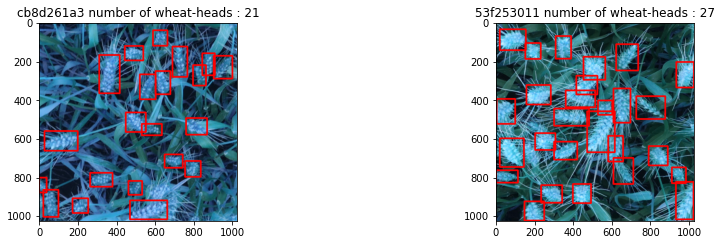

In [46]:
detection_threshold = 0.7
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        image = image.cpu()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        ax = fig.add_subplot(2,2,i+1)
        sample = image, {'boxes':boxes}, image_id
        img = boxed_image(sample)
        title = f'{image_id} number of wheat-heads : {len(boxes)}'
        ax.set_title(title)
        ax.imshow(img)
plt.show()



In [48]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9917 71 4 100 158 0.9830 616 916 77 105 0.98...
1,51f1be19e,0.9827 277 471 135 117 0.9813 607 79 155 182 0...
2,f5a1f0358,0.9789 891 642 81 141 0.9776 289 459 162 99 0....
3,796707dd7,0.9674 509 788 83 86 0.9624 901 335 89 82 0.95...
4,51b3e36ab,0.9930 871 288 151 143 0.9896 234 644 92 154 0...


In [49]:
test_df.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>